# all coupons

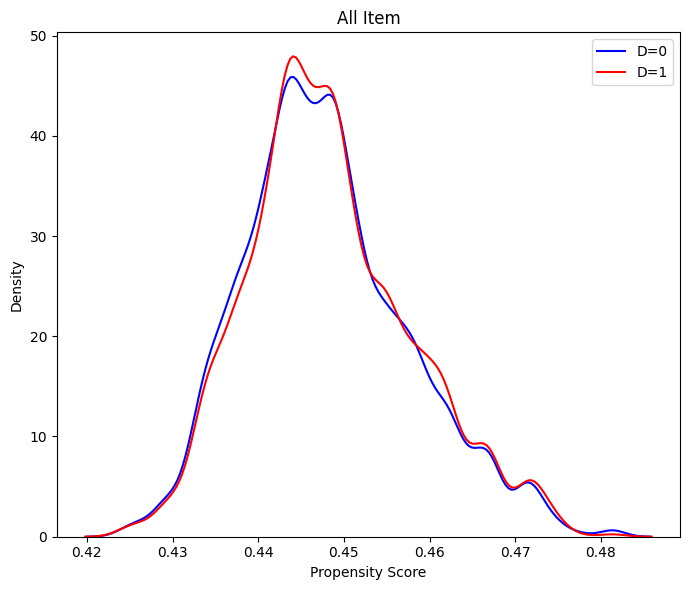

Estimated ATE (AIPW): 9.212
True ATE: 10.689
Error ATE: 1.477
PEHE: 118.503
Number of negative AIPW estimates: 10548
Number of positive AIPW estimates: 11878


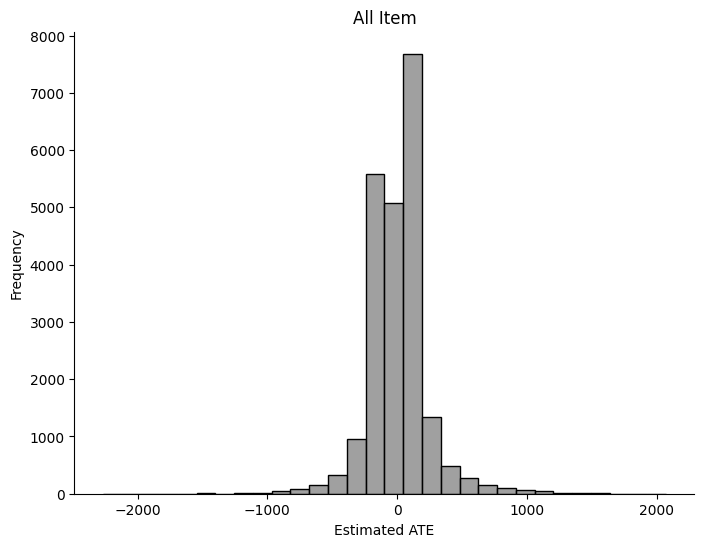

The main concentration of estimated ATE is between -98.262 and 191.267
Within the main concentration range [-98.262, 191.267]:
Number of negative AIPW estimates: 3361
Number of positive AIPW estimates: 9391


In [5]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('/content/customer_transaction_different_coupons.csv')

# Define features (X), treatment (T), and outcome (Y)
features = ['age_range', 'rented', 'family_size', 'income_bracket']
X = df[features]
T = df['coupon_id']
Y = df['avg_daily_expenditures']

# Split data into train and test sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

# Step 1: Estimate propensity scores using logistic regression
propensity_model = LogisticRegression()
propensity_model.fit(X_train, T_train)
#propensity_scores_train = propensity_model.predict_proba(X_train)[:, 1]
propensity_scores_test = propensity_model.predict_proba(X_test)[:, 1]

# Step 2: Trim propensity scores to avoid extreme values
trim_lower = 0.01
trim_upper = 0.99

# Apply trimming
keep_indices = (propensity_scores_test > trim_lower) & (propensity_scores_test < trim_upper)
X_test_trimmed = X_test[keep_indices]
T_test_trimmed = T_test[keep_indices]
Y_test_trimmed = Y_test[keep_indices]
propensity_scores_test_trimmed = propensity_scores_test[keep_indices]

# Separate propensity scores for T_test=1 and T_test=0
propensity_scores_test_T1 = propensity_scores_test[T_test_trimmed == 1]
propensity_scores_test_T0 = propensity_scores_test[T_test_trimmed == 0]

# Plot propensity score distributions
plt.figure(figsize=(7, 6))

sns.kdeplot(propensity_scores_test_T0, color="blue", label='D=0')
sns.kdeplot(propensity_scores_test_T1, color="red", label='D=1')

plt.title('All Item')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Step 3: Train outcome models for treated and untreated groups
outcome_model_treated = xgb.XGBRegressor(
    n_estimators=350,
    max_depth=8,
    learning_rate=1e-2,
    n_jobs=-1,
    tree_method="hist"
)

outcome_model_untreated = xgb.XGBRegressor(
    n_estimators=350,
    max_depth=8,
    learning_rate=1e-2,
    n_jobs=-1,
    tree_method="hist"
)

outcome_model_treated.fit(
    X_train[T_train == 1],
    Y_train[T_train == 1]
)

outcome_model_untreated.fit(
    X_train[T_train == 0],
    Y_train[T_train == 0]
)

# Step 4: Predict outcomes on the test set for treated and untreated
Y_test_pred_1 = outcome_model_treated.predict(X_test_trimmed)
Y_test_pred_0 = outcome_model_untreated.predict(X_test_trimmed)

# Step 5: Calculate the AIPW estimator on the trimmed test set
propensity_scores_test_trimmed = np.clip(propensity_scores_test_trimmed, 1e-10, 1 - 1e-10)

aipw_test = (T_test_trimmed * (Y_test_trimmed - Y_test_pred_1) / propensity_scores_test_trimmed) - \
            ((1 - T_test_trimmed) * (Y_test_trimmed - Y_test_pred_0) / (1 - propensity_scores_test_trimmed)) + \
            Y_test_pred_1 - Y_test_pred_0

# Step 6: Calculate the AIPW estimate of ATE on the trimmed test set
ATE_aipw = np.mean(aipw_test)
print(f"Estimated ATE (AIPW): {ATE_aipw:.3f}")

# Calculate the real ATE on the trimmed test set
Y_test_treated = Y_test_trimmed[T_test_trimmed == 1]
Y_test_untreated = Y_test_trimmed[T_test_trimmed == 0]

if len(Y_test_treated) > 0 and len(Y_test_untreated) > 0:
    ATE_real = np.mean(Y_test_treated) - np.mean(Y_test_untreated)
    print(f"True ATE: {ATE_real:.3f}")
else:
    ATE_real = np.nan
    print(f"True ATE: Not available (empty group)")

# Calculate the Absolute Error in ATE
absolute_error_ate = np.abs(ATE_aipw - ATE_real)
print(f"Error ATE: {absolute_error_ate:.3f}")

# Calculate PEHE
true_ite = np.where(T_test_trimmed == 1, Y_test_trimmed - np.mean(Y_test_treated), Y_test_trimmed - np.mean(Y_test_untreated))
estimated_ite = Y_test_pred_1 - Y_test_pred_0

pehe = np.sqrt(np.mean((true_ite - estimated_ite) ** 2))
print(f"PEHE: {pehe:.3f}")


# Calculate the number of negative and positive AIPW estimates
num_negative = np.sum(aipw_test < 0)
num_positive = np.sum(aipw_test > 0)

print(f"Number of negative AIPW estimates: {num_negative}")
print(f"Number of positive AIPW estimates: {num_positive}")

# Plot histogram for this category
plt.figure(figsize=(8, 6))
sns.histplot(aipw_test, bins=30, color='gray', edgecolor='black')
plt.title(f'All Item')
plt.xlabel('Estimated ATE')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)
plt.show()

# Calculate the range where the majority of the estimates lie
hist, bin_edges = np.histogram(aipw_test, bins=30)
max_bin_index = np.argmax(hist)
main_concentration_start = bin_edges[max_bin_index-1]
main_concentration_end = bin_edges[max_bin_index + 1]

print(f"The main concentration of estimated ATE is between {main_concentration_start:.3f} and {main_concentration_end:.3f}")

# Calculate number of negative and positive AIPW estimates within the main concentration range
num_negative_in_concentration = np.sum((aipw_test >= main_concentration_start) & (aipw_test <= main_concentration_end) & (aipw_test < 0))
num_positive_in_concentration = np.sum((aipw_test >= main_concentration_start) & (aipw_test <= main_concentration_end) & (aipw_test > 0))

print(f"Within the main concentration range [{main_concentration_start:.3f}, {main_concentration_end:.3f}]:")
print(f"Number of negative AIPW estimates: {num_negative_in_concentration}")
print(f"Number of positive AIPW estimates: {num_positive_in_concentration}")

#Bootstrap-all coupons

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Read the dataset
df = pd.read_csv('/content/customer_transaction_different_coupons.csv')

# Define features (X), treatment (T), and outcome (Y)
features = ['age_range', 'rented', 'family_size', 'income_bracket']
X = df[features]
T = df['coupon_id']
Y = df['avg_daily_expenditures']

# Split data into train and test sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

# Initialize dictionary to store bootstrap results
bootstrap_results = {}

# Number of bootstrap samples
n_bootstrap = 1000

# Bootstrap function to calculate CATE
def bootstrap_cate(X_train, T_train, Y_train, X_test, T_test, Y_test):
    n = len(X_train)
    indices = np.random.choice(n, n, replace=True)
    X_train_bootstrap = X_train.iloc[indices]
    T_train_bootstrap = T_train.iloc[indices]
    Y_train_bootstrap = Y_train.iloc[indices]

    # Estimate propensity score
    propensity_model = LogisticRegression()
    propensity_model.fit(X_train_bootstrap, T_train_bootstrap)
    propensity_scores_test = propensity_model.predict_proba(X_test)[:, 1]

    # Trim propensity scores to avoid extreme values
    trim_lower = 0.01
    trim_upper = 0.99
    propensity_scores_test = np.clip(propensity_scores_test, trim_lower, trim_upper)

    # Estimate outcome models for treated and untreated groups
    outcome_model_treated = xgb.XGBRegressor(n_estimators=350, max_depth=8, learning_rate=1e-2, n_jobs=-1, tree_method="hist")
    outcome_model_untreated = xgb.XGBRegressor(n_estimators=350, max_depth=8, learning_rate=1e-2, n_jobs=-1, tree_method="hist")

    outcome_model_treated.fit(X_train_bootstrap[T_train_bootstrap == 1], Y_train_bootstrap[T_train_bootstrap == 1])
    outcome_model_untreated.fit(X_train_bootstrap[T_train_bootstrap == 0], Y_train_bootstrap[T_train_bootstrap == 0])

    # Predict outcomes
    Y_test_pred_1 = outcome_model_treated.predict(X_test)
    Y_test_pred_0 = outcome_model_untreated.predict(X_test)

    # Calculate AIPW
    aipw_test = (T_test * (Y_test - Y_test_pred_1) / propensity_scores_test) - \
                ((1 - T_test) * (Y_test - Y_test_pred_0) / (1 - propensity_scores_test)) + \
                Y_test_pred_1 - Y_test_pred_0

    return np.mean(aipw_test)

# Perform bootstrap to get distribution of CATE estimates
bootstrap_cates = []
for _ in range(n_bootstrap):
    boot_cate = bootstrap_cate(X_train, T_train, Y_train, X_test, T_test, Y_test)
    bootstrap_cates.append(boot_cate)

bootstrap_cates = np.array(bootstrap_cates)

# Calculate mean and standard error
mean_cate = np.mean(bootstrap_cates)
se_cate = np.std(bootstrap_cates, ddof=1)

# Calculate p-value (two-tailed test)
p_value = 2 * (1 - np.mean(bootstrap_cates > 0))

# Determine significance level
if p_value < 0.001:
    significance_level = '***'
elif p_value < 0.01:
    significance_level = '**'
elif p_value < 0.05:
    significance_level = '*'
else:
    significance_level = 'ns'

# Store results
bootstrap_results['overall'] = {
    'mean': mean_cate,
    'standard_error': se_cate,
    'p_value': p_value,
    'significance_level': significance_level
}

print(f"Overall Mean CATE: {mean_cate:.3f}, SE: {se_cate:.3f}, P-value: {p_value:.4f}, Significance: {significance_level}")


Overall Mean CATE: 9.160, SE: 0.100, P-value: 0.0000, Significance: ***


#different coupons

Estimated CATE for Others: -10.455
Absolute Error in ATE for Others: 1.820
PEHE for Others: 56.698


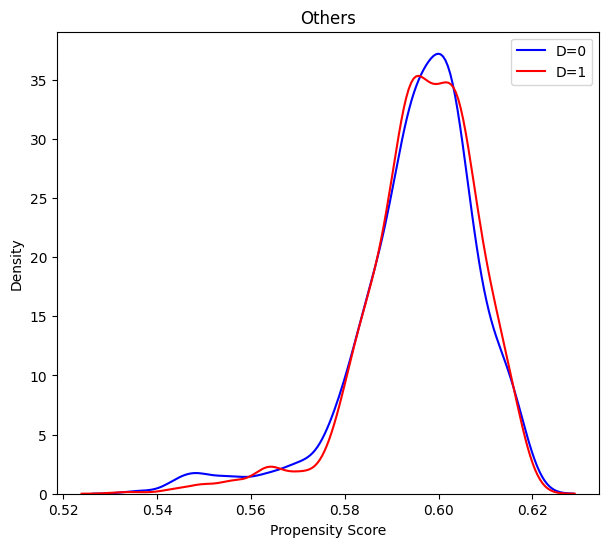

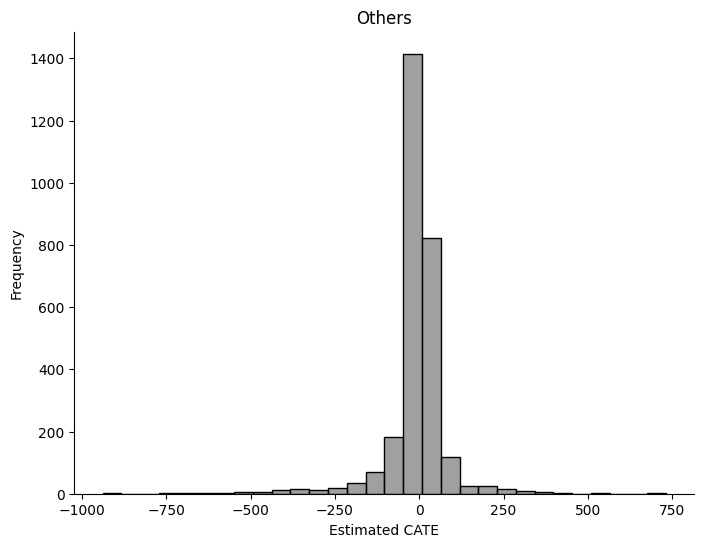

Estimated CATE for Health and Personal Care: 11.162
Absolute Error in ATE for Health and Personal Care: 2.135
PEHE for Health and Personal Care: 79.935


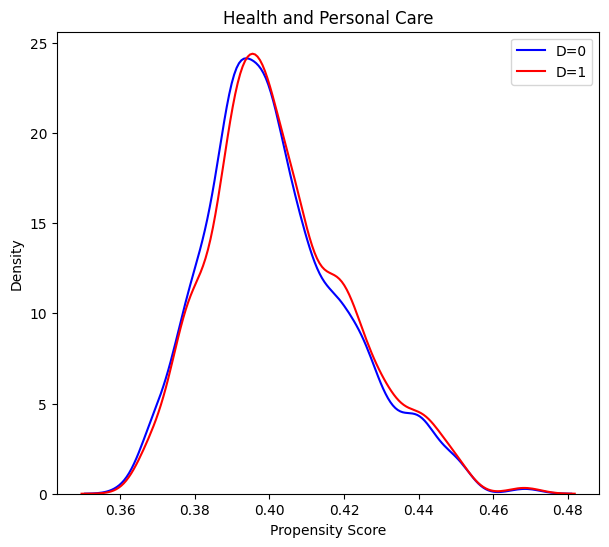

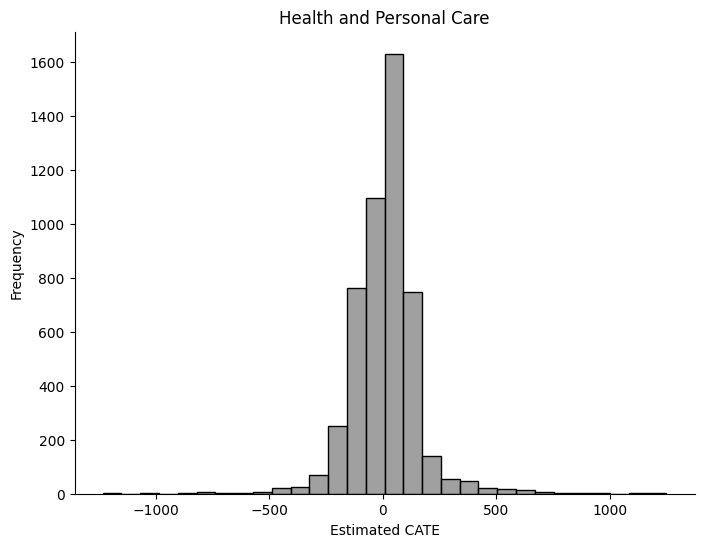

Estimated CATE for Daily Food: 21.524
Absolute Error in ATE for Daily Food: 6.446
PEHE for Daily Food: 145.638


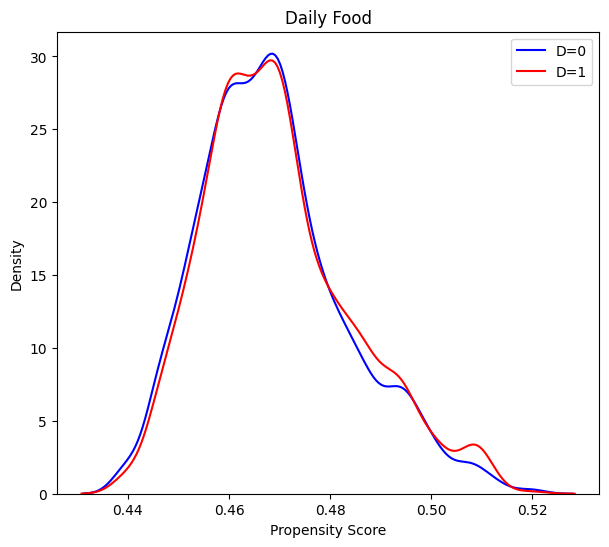

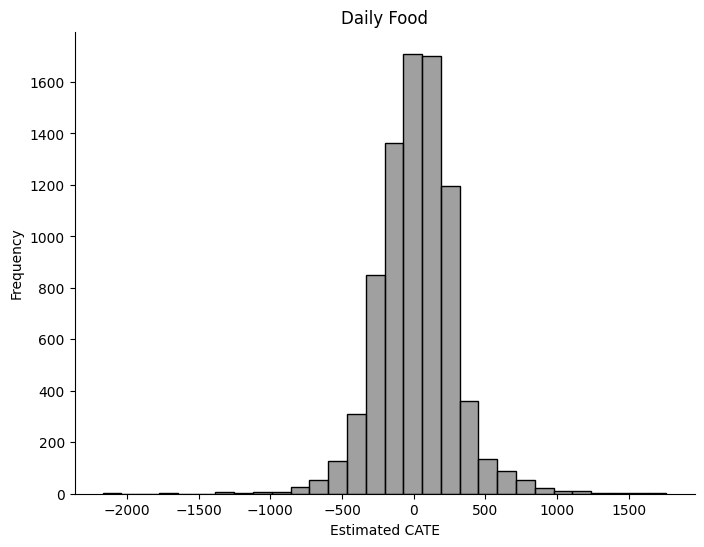

Estimated CATE for Meat and Seafood: 1.968
Absolute Error in ATE for Meat and Seafood: 0.753
PEHE for Meat and Seafood: 41.885


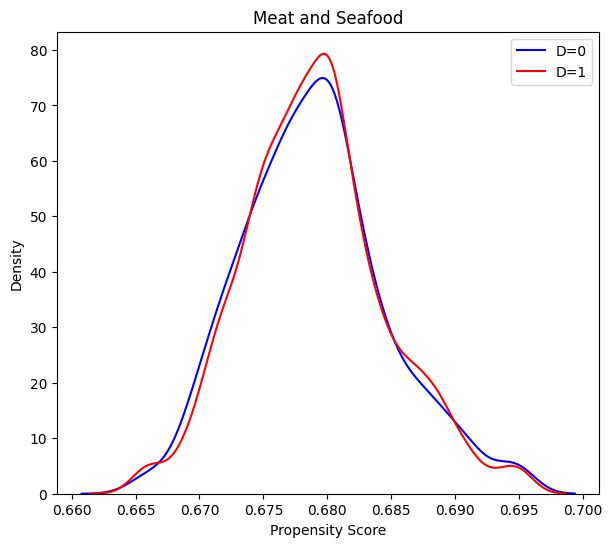

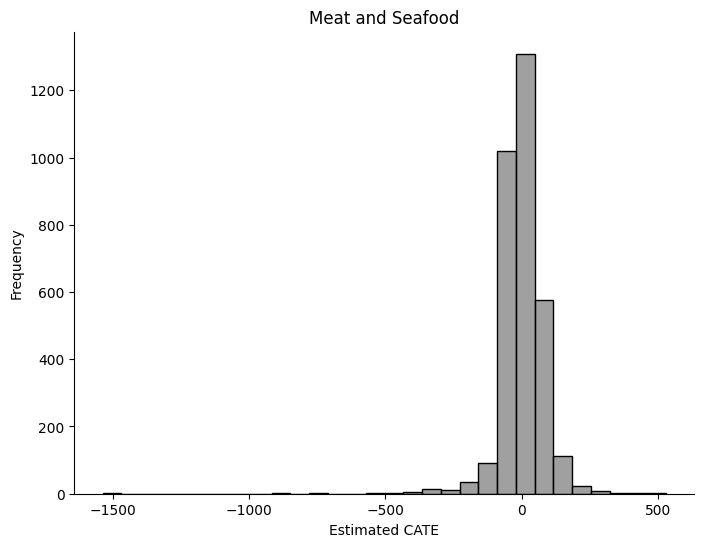

Estimated CATE for Special and Ready-to-Eat Food: 11.701
Absolute Error in ATE for Special and Ready-to-Eat Food: 1.096
PEHE for Special and Ready-to-Eat Food: 33.576


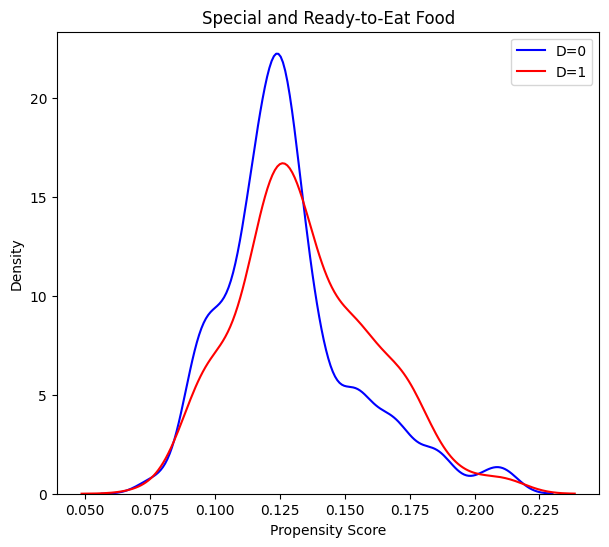

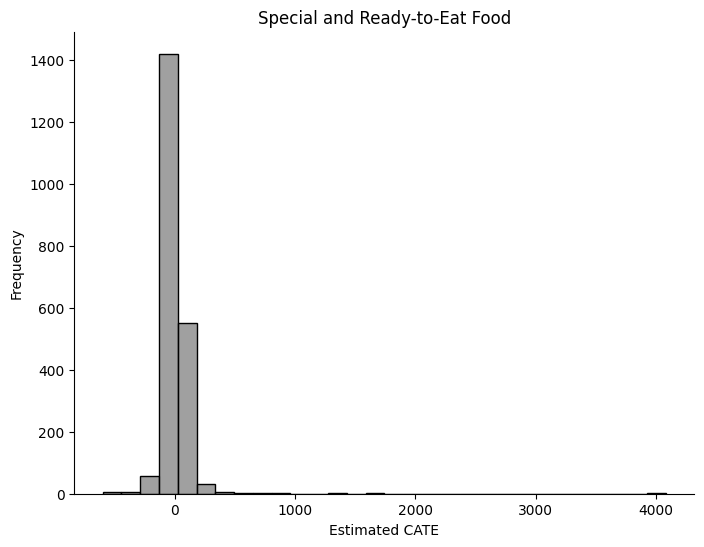

Estimated CATE for Home and Garden: 0.233
Absolute Error in ATE for Home and Garden: 0.359
PEHE for Home and Garden: 53.517


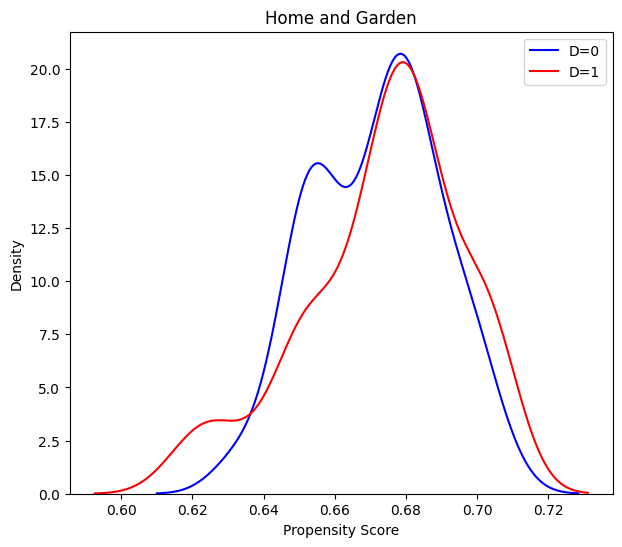

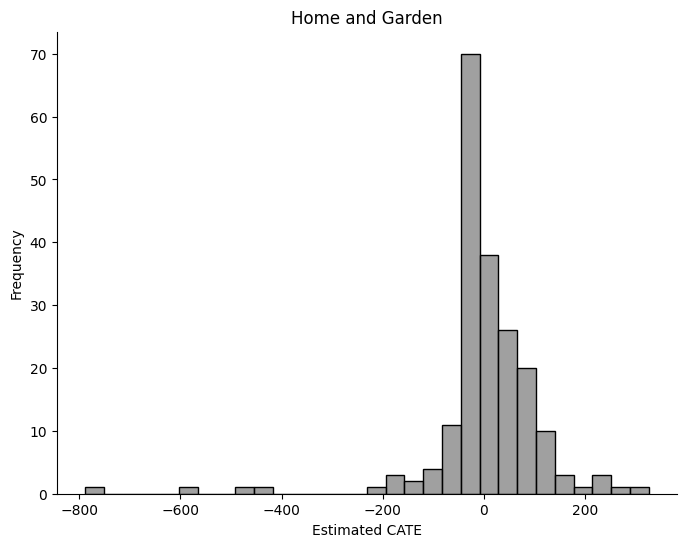

Estimated CATE for Fuel and Services: -99.721
Absolute Error in ATE for Fuel and Services: 12.183
PEHE for Fuel and Services: 122.722


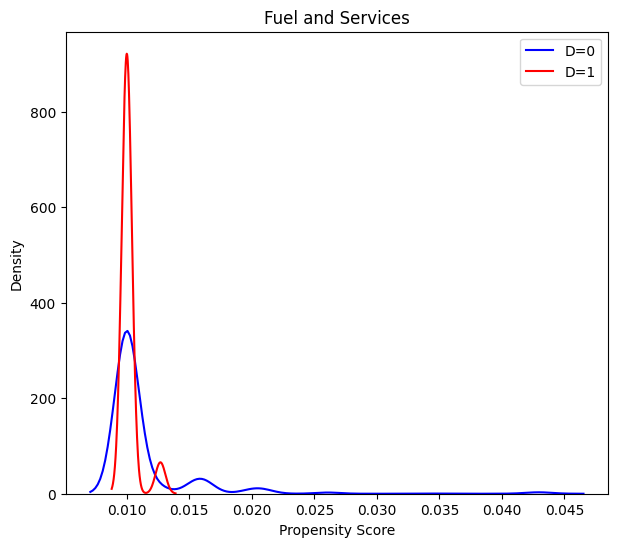

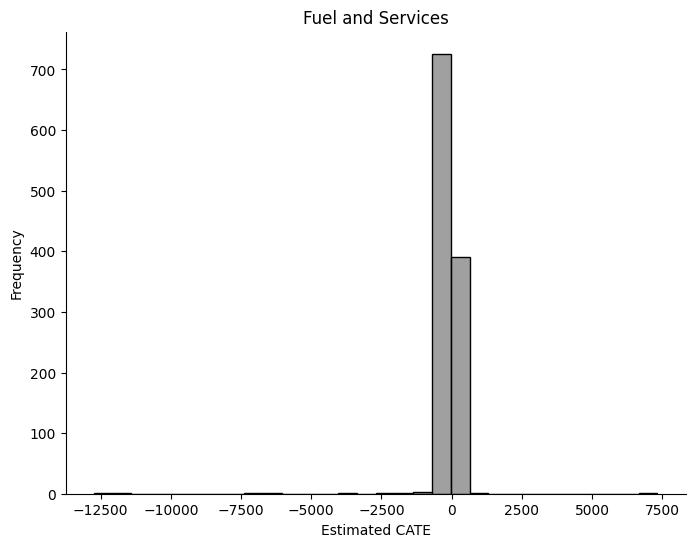

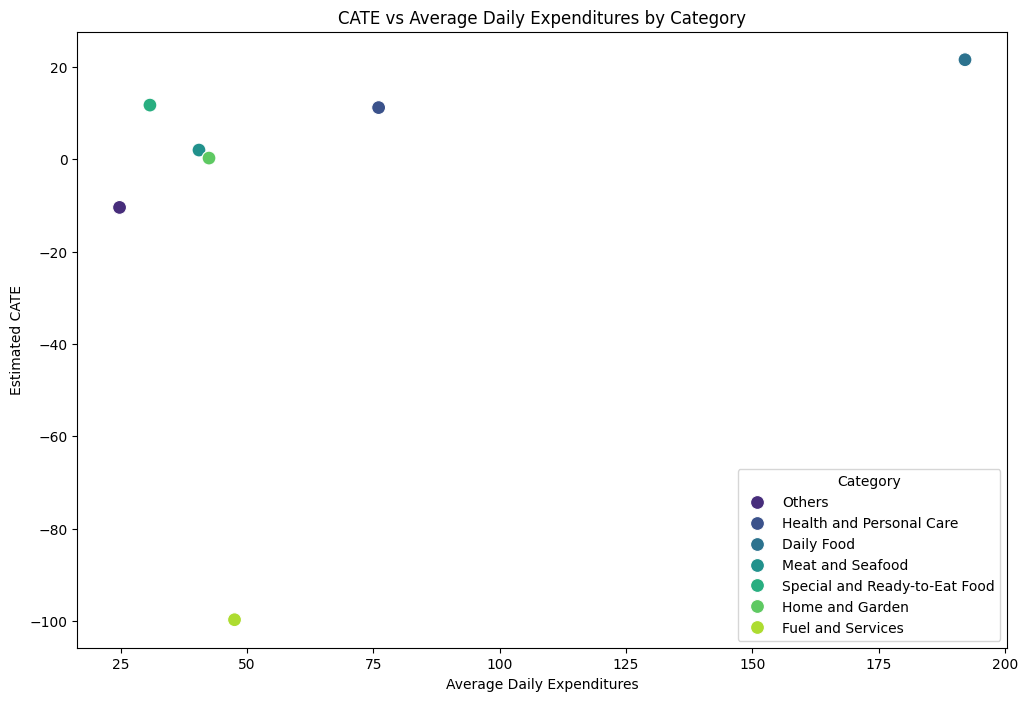

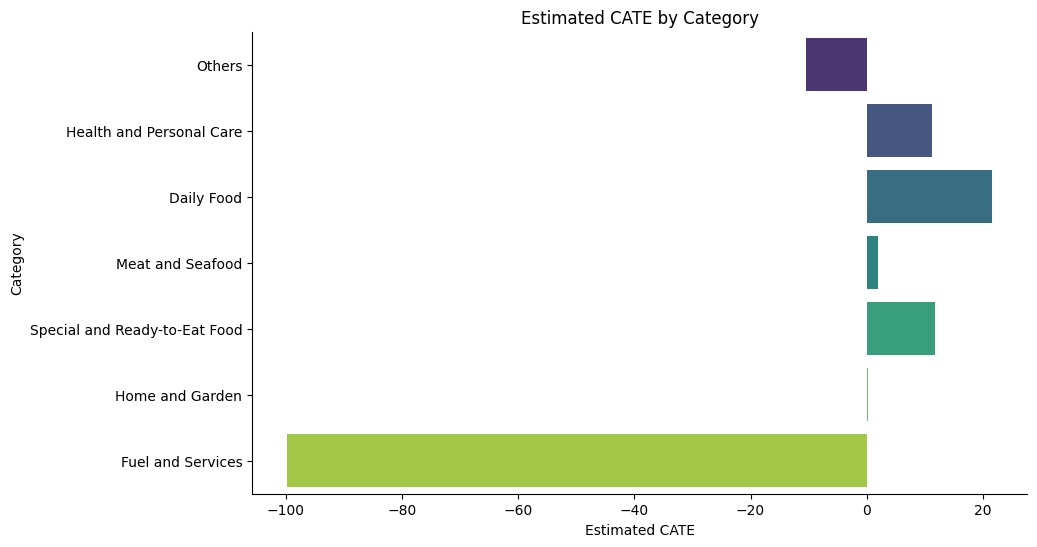

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Read the dataset
df = pd.read_csv('/content/customer_transaction_different_coupons.csv')

# Define features (X), treatment (T), and outcome (Y)
features = ['age_range', 'rented', 'family_size', 'income_bracket']
X = df[features]
T = df['coupon_id']
Y = df['avg_daily_expenditures']

# Add the new category variable
new_category = df['new_category']

# Split data into train and test sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

# Get unique categories from the new_category variable
categories = df['new_category'].unique()

# Initialize dictionaries to store CATE and average expenditures
cate_dict = {}
avg_daily_expenditures_dict = {}

absolute_error_dict = {}
pehe_dict = {}

# Iterate over each category to calculate CATE, Absolute Error, and PEHE
for category in categories:
    # Select data for the current category
    train_category_mask = (df['new_category'] == category)
    test_category_mask = (df['new_category'] == category)

    X_train_category = X_train[train_category_mask]
    T_train_category = T_train[train_category_mask]
    Y_train_category = Y_train[train_category_mask]

    X_test_category = X_test[test_category_mask]
    T_test_category = T_test[test_category_mask]
    Y_test_category = Y_test[test_category_mask]

    # Step 1: Estimate propensity score using logistic regression
    propensity_model = LogisticRegression()
    propensity_model.fit(X_train_category, T_train_category)
    propensity_scores_test = propensity_model.predict_proba(X_test_category)[:, 1]

    # Step 2: Trim propensity scores to avoid extreme values
    trim_lower = 0.01
    trim_upper = 0.99

    # Trim propensity scores
    propensity_scores_test = np.clip(propensity_scores_test, trim_lower, trim_upper)

    # Separate propensity scores for T_test=1 and T_test=0
    propensity_scores_test_T1 = propensity_scores_test[T_test_category == 1]
    propensity_scores_test_T0 = propensity_scores_test[T_test_category == 0]

    # Plot propensity score distributions
    plt.figure(figsize=(7, 6))

    sns.kdeplot(propensity_scores_test_T0, color="blue", label='D=0')
    sns.kdeplot(propensity_scores_test_T1, color="red", label='D=1')

    plt.title(category)
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.legend()

    # Step 2: Estimate outcome model for treated and untreated groups
    outcome_model_treated = xgb.XGBRegressor(n_estimators=350, max_depth=8, learning_rate=1e-2, n_jobs=-1, tree_method="hist")
    outcome_model_untreated = xgb.XGBRegressor(n_estimators=350, max_depth=8, learning_rate=1e-2, n_jobs=-1, tree_method="hist")

    # Train outcome models
    outcome_model_treated.fit(X_train_category[T_train_category == 1], Y_train_category[T_train_category == 1])
    outcome_model_untreated.fit(X_train_category[T_train_category == 0], Y_train_category[T_train_category == 0])

    # Step 3: Predict outcomes on the test set for the current category
    Y_test_pred_1 = outcome_model_treated.predict(X_test_category)
    Y_test_pred_0 = outcome_model_untreated.predict(X_test_category)

    # Step 4: Calculate AIPW for the test set
    aipw_test = (T_test_category * (Y_test_category - Y_test_pred_1) / propensity_scores_test) - \
                ((1 - T_test_category) * (Y_test_category - Y_test_pred_0) / (1 - propensity_scores_test)) + \
                Y_test_pred_1 - Y_test_pred_0

    # Calculate CATE for the current category
    CATE = np.mean(aipw_test)
    cate_dict[category] = CATE
    print(f"Estimated CATE for {category}: {CATE:.3f}")

    # Step 5: Calculate the real ATE on the trimmed test set
    Y_test_treated = Y_test_category[T_test_category == 1]
    Y_test_untreated = Y_test_category[T_test_category == 0]

    if len(Y_test_treated) > 0 and len(Y_test_untreated) > 0:
        ATE_real = np.mean(Y_test_treated) - np.mean(Y_test_untreated)
    else:
        ATE_real = np.nan  # Handle cases where there is no treated/untreated data

    # Calculate Absolute Error in ATE
    absolute_error_ate = np.abs(CATE - ATE_real)
    absolute_error_dict[category] = absolute_error_ate
    print(f"Absolute Error in ATE for {category}: {absolute_error_ate:.3f}")

    # Step 6: Calculate PEHE for the current category
    true_ite = np.where(T_test_category == 1, Y_test_category - np.mean(Y_test_treated), Y_test_category - np.mean(Y_test_untreated))
    estimated_ite = Y_test_pred_1 - Y_test_pred_0

    pehe = np.sqrt(np.mean((true_ite - estimated_ite) ** 2))
    pehe_dict[category] = pehe
    print(f"PEHE for {category}: {pehe:.3f}")

    # Calculate and store average daily expenditures (based on predictions)
    avg_daily_expenditures_dict[category] = np.mean(Y_test_pred_1)

    # Plot histogram for this category
    plt.figure(figsize=(8, 6))
    sns.histplot(aipw_test, bins=30, color='gray', edgecolor='black')
    plt.title(category)
    plt.xlabel('Estimated CATE')
    plt.ylabel('Frequency')
    sns.despine(top=True, right=True)
    plt.show()

# Visualization of results for each category
results_df = pd.DataFrame({
    'Category': list(cate_dict.keys()),
    'CATE': list(cate_dict.values()),
    'Absolute Error': list(absolute_error_dict.values()),
    'PEHE': list(pehe_dict.values()),
    'Average Daily Expenditures': [avg_daily_expenditures_dict[cat] for cat in cate_dict.keys()]
})

# Scatter plot of CATE vs Average Daily Expenditures
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Average Daily Expenditures', y='CATE', hue='Category', data=results_df, palette='viridis', s=100)
plt.xlabel('Average Daily Expenditures')
plt.ylabel('Estimated CATE')
plt.title('CATE vs Average Daily Expenditures by Category')
plt.show()

# Bar plot of CATE for each category
cate_df = pd.DataFrame(list(cate_dict.items()), columns=['Category', 'CATE'])
plt.figure(figsize=(10, 6))
sns.barplot(x='CATE', y='Category', data=cate_df, palette='viridis')
plt.xlabel('Estimated CATE')
plt.ylabel('Category')
plt.title('Estimated CATE by Category')
sns.despine(top=True, right=True)
plt.show()



#Bootstrap-different coupons

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Read the dataset
df = pd.read_csv('/content/customer_transaction_different_coupons.csv')

# Define features (X), treatment (T), and outcome (Y)
features = ['age_range', 'rented', 'family_size', 'income_bracket']
X = df[features]
T = df['coupon_id']
Y = df['avg_daily_expenditures']

# Add the new category variable
new_category = df['new_category']

# Split data into train and test sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

# Get unique categories from the new_category variable
categories = df['new_category'].unique()

# Initialize dictionaries to store CATE and average expenditures
cate_dict = {}
avg_daily_expenditures_dict = {}
absolute_error_dict = {}
pehe_dict = {}
bootstrap_results = {}

# Number of bootstrap samples
n_bootstrap = 1000

# Bootstrap function to calculate CATE
def bootstrap_cate(X_train, T_train, Y_train, X_test, T_test, Y_test):
    n = len(X_train)
    indices = np.random.choice(n, n, replace=True)
    X_train_bootstrap = X_train.iloc[indices]
    T_train_bootstrap = T_train.iloc[indices]
    Y_train_bootstrap = Y_train.iloc[indices]

    # Estimate propensity score
    propensity_model = LogisticRegression()
    propensity_model.fit(X_train_bootstrap, T_train_bootstrap)
    propensity_scores_test = propensity_model.predict_proba(X_test)[:, 1]

   # Step 2: Trim propensity scores to avoid extreme values
    trim_lower = 0.01
    trim_upper = 0.99

    # Trim propensity scores
    propensity_scores_test = np.clip(propensity_scores_test, trim_lower, trim_upper)

    # Estimate outcome models for treated and untreated groups
    outcome_model_treated = xgb.XGBRegressor(n_estimators=350, max_depth=8, learning_rate=1e-2, n_jobs=-1, tree_method="hist")
    outcome_model_untreated = xgb.XGBRegressor(n_estimators=350, max_depth=8, learning_rate=1e-2, n_jobs=-1, tree_method="hist")

    outcome_model_treated.fit(X_train_bootstrap[T_train_bootstrap == 1], Y_train_bootstrap[T_train_bootstrap == 1])
    outcome_model_untreated.fit(X_train_bootstrap[T_train_bootstrap == 0], Y_train_bootstrap[T_train_bootstrap == 0])

    # Predict outcomes
    Y_test_pred_1 = outcome_model_treated.predict(X_test)
    Y_test_pred_0 = outcome_model_untreated.predict(X_test)

    # Calculate AIPW
    aipw_test = (T_test * (Y_test - Y_test_pred_1) / propensity_scores_test) - \
                ((1 - T_test) * (Y_test - Y_test_pred_0) / (1 - propensity_scores_test)) + \
                Y_test_pred_1 - Y_test_pred_0

    return np.mean(aipw_test)

# Iterate over each category to calculate CATE, Absolute Error, PEHE, and Bootstrap statistics
for category in categories:
    # Select data for the current category
    train_category_mask = (df['new_category'] == category)
    test_category_mask = (df['new_category'] == category)

    X_train_category = X_train[train_category_mask]
    T_train_category = T_train[train_category_mask]
    Y_train_category = Y_train[train_category_mask]

    X_test_category = X_test[test_category_mask]
    T_test_category = T_test[test_category_mask]
    Y_test_category = Y_test[test_category_mask]

    # Estimate CATE without bootstrap
    CATE = bootstrap_cate(X_train_category, T_train_category, Y_train_category, X_test_category, T_test_category, Y_test_category)
    cate_dict[category] = CATE

    # Perform bootstrap to get distribution of CATE estimates
    bootstrap_cates = []
    for _ in range(n_bootstrap):
        boot_cate = bootstrap_cate(X_train_category, T_train_category, Y_train_category, X_test_category, T_test_category, Y_test_category)
        bootstrap_cates.append(boot_cate)

    bootstrap_cates = np.array(bootstrap_cates)

    # Calculate mean and standard error
    mean_cate = np.mean(bootstrap_cates)
    se_cate = np.std(bootstrap_cates, ddof=1)

    # Calculate p-value (two-tailed test)
    p_value = 2 * (1 - np.mean(bootstrap_cates > 0))

    # Determine significance level
    if p_value < 0.001:
        significant_level = '***'
    elif p_value < 0.01:
        significant_level = '**'
    elif p_value < 0.05:
        significant_level = '*'
    else:
        significant_level = 'ns'

    # Store results
    bootstrap_results[category] = {
        'mean': mean_cate,
        'standard_error': se_cate,
        'p_value': p_value,
        'significance_level': significant_level
    }

    print(f"Category: {category}, Mean CATE: {mean_cate:.3f}, SE: {se_cate:.3f}, P-value: {p_value:.4f}, Significance: {significant_level}")



Category: Others, Mean CATE: -10.480, SE: 0.239, P-value: 2.0000, Significance: ns
Category: Health and Personal Care, Mean CATE: 11.099, SE: 0.206, P-value: 0.0000, Significance: ***
Category: Daily Food, Mean CATE: 21.480, SE: 0.292, P-value: 0.0000, Significance: ***
Category: Meat and Seafood, Mean CATE: 1.977, SE: 0.184, P-value: 0.0000, Significance: ***
Category: Special and Ready-to-Eat Food, Mean CATE: 11.849, SE: 0.654, P-value: 0.0000, Significance: ***
Category: Home and Garden, Mean CATE: 0.750, SE: 2.282, P-value: 0.7820, Significance: ns
Category: Fuel and Services, Mean CATE: -104.979, SE: 14.165, P-value: 2.0000, Significance: ns
